In [11]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

In [68]:
# original 
ratings = [ load_json(F"../data/ratings/tasks_ratings_{i}.json") for i in range(3)]

# with human ratings
rating_hm = load_json("../data/ratings/tasks_ratings_hm.json")
rating_gpt_ex = load_json("../data/ratings/tasks_ratings_gptex.json")

# final post-processed labels for each utterance.
final_labels = pd.read_csv("../scripts/final_labels.csv")
final_labels = final_labels.astype({'utterance_id': 'str'})

# rating with claim labels
claim_ratings = load_json("../data/ratings/tasks_ratings.json")

In [16]:
# get utterances information df
utts_info = []
for corpus in ["fora", "insq"]:
    for task in ratings[0]:
        if corpus not in task["task_id"]:
            continue
        utts = task["target_utterances"]
        for utt in utts:
            if utt["skipped"]:
                continue
            text = utt["utterance_text"]
            length = len(text.split(" "))
            conv_id = corpus + "_" + str(utt['conversation_id']).split("_")[-1]
            utts_info.append({'corpus': corpus, "conversation_id": conv_id,'utterance_index': utt['utterance_index'], 'utterance_id': str(utt['utterance_id']), "text": text, "length": length})
utts_df = pd.DataFrame(utts_info)

In [17]:
# Getting the human soft and hard labels.

# Pivot so that aspects are columns
final_df = final_labels.pivot_table(
    index=["corpus", "conv_id", "utterance_id"],   # keep utterance identifiers
    columns="aspect",                              # spread aspects across columns
    values=["n_raters","y_hard","w_conf","p1","p2","p3","p4","y_cont","lo","hi",
            "mask_t1","mask_t2","mask_t3"],        # values to pivot
    aggfunc="first"                                # if duplicates, take first
)

# Flatten the multi-level column index (e.g. ('y_hard','Novelty') → 'y_hard_Novelty')
final_df.columns = [f"{val}_{aspect}" for val, aspect in final_df.columns]

# Reset index so corpus/conv_id/utterance_id are normal columns
final_df = final_df.reset_index()
final_df = pd.merge(final_df, utts_df[["utterance_id", 'utterance_index', "text", "length"]], how="left", on=["utterance_id"])
# use soft label
soft_df = final_df[['corpus', 'conv_id', 'utterance_id', 'utterance_index', 'y_cont_CIG',
       'y_cont_Novelty', 'y_cont_Relevance', 'y_cont_Scope', "text", "length"]]
soft_df = soft_df.rename(columns={'y_cont_CIG': 'info', 'y_cont_Novelty': 'novo', 'y_cont_Relevance':"relv", "y_cont_Scope": "imsc"})
# use hard labels
hard_df = final_df[['corpus', 'conv_id', 'utterance_id', 'utterance_index', 'y_hard_CIG',
       'y_hard_Novelty', 'y_hard_Relevance', 'y_hard_Scope', "text", "length"]]

hard_df = hard_df.rename(columns={'y_hard_CIG': 'info', 'y_hard_Novelty': 'novo', 'y_hard_Relevance':"relv", "y_hard_Scope": "imsc"})

In [51]:
from typing import Any, Dict, List, Sequence, Tuple

ASPECTS = ["info", "novo", "relv", "imsc"]
HARD_LABELS = [1, 2, 3, 4]

aspect_decoder = {
    "info": "informativeness",
    "novo": "novelty",
    "relv": "relevance",
    "imsc": "implication_scope",
}

def get_groundtruth(
    ratings: List[Dict[str, Any]],
    soft_df: pd.DataFrame,
    hard_df: pd.DataFrame,
    corpus: str | None = None,
    aspects: Sequence[str] = ASPECTS,
) -> Dict[str, Any]:
    """
    Build a ground_truth labels dict from preprocessed soft_df / hard_df.

    soft_df, hard_df columns:
      ['corpus', 'conv_id', 'utterance_id', 'utterance_index',
       'info', 'novo', 'relv', 'imsc', 'text', 'length']

    Returns:
      {
        "ids": [utt_id1, utt_id2, ...],
        "soft": {aspect: [float, ...], ...},
        "hard": {aspect: [int, ...], ...},
      }
    """
    labels: Dict[str, Any] = {"ids": [], "hard": {}, "soft": {}}

    for task in ratings:
        conv_id = task["conversation_id"]
        if corpus is not None and task.get("corpus_id") != corpus:
            continue

        # target span for this task
        start = task["target_utterances"][0]["utterance_index"]
        end = task["target_utterances"][-1]["utterance_index"] + 1

        sub_soft = soft_df[
            (soft_df["conv_id"] == conv_id)
            & (soft_df["utterance_index"] >= start)
            & (soft_df["utterance_index"] < end)
        ]
        sub_hard = hard_df[
            (hard_df["conv_id"] == conv_id)
            & (hard_df["utterance_index"] >= start)
            & (hard_df["utterance_index"] < end)
        ]

        utt_ids = sub_soft["utterance_id"].tolist()
        labels["ids"].extend(utt_ids)

        for aspect in aspects:
            for label_type, df in [("hard", sub_hard), ("soft", sub_soft)]:
                if aspect not in labels[label_type]:
                    labels[label_type][aspect] = []
                labels[label_type][aspect].extend(df[aspect].tolist())

    return labels


def get_predictions(
    ratings: List[Dict[str, Any]],
    soft_df: pd.DataFrame,
    corpus: str | None = None,
    models: Sequence[str] | None = None,
    aspects: Sequence[str] = ASPECTS,
) -> Dict[str, Any]:
    """
    Extract prediction labels dict from ratings (which contain 'predictions').

    Assumes predictions are stored in each task as:
      task["predictions"][model][method] = [
          {
            "utterance_index": int,
            "informativeness": int,
            "novelty": int,
            "relevance": int,
            "implication_scope": int,
          }, ...
      ]

    Returns:
      {
        "ids": [...],
        "<model>_<method>": {
            "info": [...],
            "novo": [...],
            ...
        },
        ...
      }
    """
    if models is None:
        models = ["gpt-5", "gpt-5-mini"]

    labels: Dict[str, Any] = {"ids": []}

    for task in ratings:
        conv_id = task["conversation_id"]
        if corpus is not None and task.get("corpus_id") != corpus:
            continue

        start = task["target_utterances"][0]["utterance_index"]
        end = task["target_utterances"][-1]["utterance_index"] + 1

        sub_soft = soft_df[
            (soft_df["conv_id"] == conv_id)
            & (soft_df["utterance_index"] >= start)
            & (soft_df["utterance_index"] < end)
        ]

        utt_indexes = sub_soft["utterance_index"].tolist()
        utt_ids = sub_soft["utterance_id"].tolist()
        labels["ids"].extend(utt_ids)

        if "predictions" not in task:
            continue

        predictions = task["predictions"]
        for model, model_preds in predictions.items():
            if model not in models:
                continue

            for method, method_pred in model_preds.items():
                method_tag = f"{model}_{method}"
                if method_tag not in labels:
                    labels[method_tag] = {asp: [] for asp in aspects}

                # We expect one prediction per utterance in utt_indexes
                addition = 0
                for pred in method_pred:
                    if pred["utterance_index"] in utt_indexes:
                        addition += 1
                        for aspect in aspects:
                            labels[method_tag][aspect].append(
                                pred[aspect_decoder[aspect]]
                            )
                # Sanity check: we saw exactly all utt_indexes
                assert addition == len(utt_indexes), (
                    f"Method {method_tag} had {addition} matching preds, "
                    f"expected {len(utt_indexes)} for conv_id={conv_id}"
                )

    return labels


In [52]:
# -------------------------- metrics --------------------------- #

def _safe_spearman(a: pd.Series, b: pd.Series) -> float:
    if a.nunique() < 2 or b.nunique() < 2:
        return np.nan
    return a.corr(b, method="spearman")


def _safe_pearson(a: pd.Series, b: pd.Series) -> float:
    if a.nunique() < 2 or b.nunique() < 2:
        return np.nan
    return a.corr(b, method="pearson")


def _confusion_matrix(y_true, y_pred, labels):
    L = len(labels)
    idx = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((L, L), dtype=float)
    for t, p in zip(y_true, y_pred):
        if t in idx and p in idx:
            cm[idx[t], idx[p]] += 1.0
    return cm


def _macro_f1(y_true, y_pred, labels=HARD_LABELS):
    cm = _confusion_matrix(y_true, y_pred, labels)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    f1s = []
    for k in range(len(labels)):
        denom = (2 * tp[k] + fp[k] + fn[k])
        f1 = 0.0 if denom == 0 else (2 * tp[k]) / denom
        f1s.append(f1)
    return float(np.mean(f1s)) if len(f1s) else np.nan


def _quadratic_weighted_kappa(y_true, y_pred, labels=HARD_LABELS):
    """
    Cohen's kappa with quadratic weights for ordinal labels.
    """
    L = len(labels)
    cm = _confusion_matrix(y_true, y_pred, labels)  # O_ij
    n = cm.sum()
    if n == 0:
        return np.nan

    # Weight matrix: w_ij = (i-j)^2 / (L-1)^2
    grid = np.arange(L)
    W = (grid[:, None] - grid[None, :]) ** 2 / float((L - 1) ** 2)

    # Row/col marginals
    r = cm.sum(axis=1)
    c = cm.sum(axis=0)

    # Expected matrix under independence: E_ij = r_i * c_j / n
    E = (r[:, None] * c[None, :]) / n if n > 0 else np.zeros_like(cm)

    # Observed vs expected weighted sums
    O_w = (W * cm).sum() / n
    E_w = (W * E).sum() / n
    if E_w == 0:
        return 1.0 if O_w == 0 else 0.0

    kappa = 1.0 - (O_w / E_w)
    return float(kappa)


In [96]:
def _validate_ground_truth_labels(
    gt_labels: Dict[str, Any],
    aspects: Sequence[str],
) -> Tuple[List[Any], int]:
    """
    ground_truth_labels is expected to be the output of get_groundtruth(...).
    """
    if "ids" not in gt_labels:
        raise ValueError("ground_truth must contain key 'ids'.")
    gt_ids = gt_labels["ids"]
    gt_len = len(gt_ids)

    soft = gt_labels.get("soft", {})
    hard = gt_labels.get("hard", {})

    for asp in aspects:
        if asp not in soft:
            raise ValueError(f"ground_truth['soft'] missing aspect {asp}.")
        if asp not in hard:
            raise ValueError(f"ground_truth['hard'] missing aspect {asp}.")
        if len(soft[asp]) != gt_len:
            raise ValueError(f"ground_truth['soft'][{asp}] length != ids length.")
        if len(hard[asp]) != gt_len:
            raise ValueError(f"ground_truth['hard'][{asp}] length != ids length.")

    return gt_ids, gt_len


def _ground_truth_labels_to_df(
    gt_labels: Dict[str, Any],
    aspects: Sequence[str],
) -> pd.DataFrame:
    """
    Turn get_groundtruth(...) output into a long DataFrame:
      id, aspect, soft_gt, hard_gt
    """
    gt_ids = gt_labels["ids"]
    rows = []
    for i, ex_id in enumerate(gt_ids):
        for asp in aspects:
            rows.append(
                (
                    ex_id,
                    asp,
                    float(gt_labels["soft"][asp][i]),
                    int(gt_labels["hard"][asp][i]),
                )
            )
    return pd.DataFrame(rows, columns=["id", "aspect", "soft_gt", "hard_gt"])


def _build_predictions_df(
    llm_runs: List[Dict[str, Any]],
    gt_ids: Sequence[Any],
    gt_len: int,
    aspects: Sequence[str],
) -> pd.DataFrame:
    """
    llm_runs is a list of label dicts as returned by get_predictions(...),
    one per run.
    """
    pred_rows = []
    for run_idx, run in enumerate(llm_runs):
        if "ids" not in run:
            raise ValueError(f"Run {run_idx} missing 'ids'.")
        run_ids = run["ids"]

        if len(run_ids) != gt_len or any(a != b for a, b in zip(run_ids, gt_ids)):
            raise ValueError(f"Run {run_idx} ids not aligned with ground truth.")

        methods = [k for k in run.keys() if k != "ids"]
        for method in methods:
            block = run[method]
            for asp in aspects:
                if asp not in block:
                    raise ValueError(
                        f"Run {run_idx}, method {method} missing aspect {asp}."
                    )
                vals = block[asp]
                if len(vals) != gt_len:
                    raise ValueError(
                        f"Run {run_idx}, method {method}, aspect {asp} len {len(vals)} != ids len {gt_len}"
                    )
                for i, ex_id in enumerate(run_ids):
                    pred_rows.append((run_idx, method, asp, ex_id, int(vals[i])))

    return pd.DataFrame(
        pred_rows,
        columns=["run", "method", "aspect", "id", "pred"],
    )


def _compute_metrics_for_group(
    g: pd.DataFrame,
    hard_labels: Sequence[int],
) -> Dict[str, Any]:
    pred = pd.to_numeric(g["pred"], errors="coerce")
    soft = pd.to_numeric(g["soft_gt"], errors="coerce")
    hard = pd.to_numeric(g["hard_gt"], errors="coerce")

    # Soft metrics
    mae_soft = (pred - soft).abs().mean()
    pearson_soft = _safe_pearson(pred, soft)

    # Hard metrics
    mae_to_hard = (pred - hard).abs().mean()
    macro_f1 = _macro_f1(hard.tolist(), pred.tolist(), labels=hard_labels)
    qwk = _quadratic_weighted_kappa(hard.tolist(), pred.tolist(), labels=hard_labels)

    return {
        "mae_soft": float(mae_soft),
        "pearson_soft": float(pearson_soft) if pd.notna(pearson_soft) else np.nan,
        "mae_to_hard": float(mae_to_hard),
        "macro_f1_hard": float(macro_f1),
        "qwk_hard": float(qwk) if pd.notna(qwk) else np.nan,
        "n_items": len(g),
    }

# ------------------------ main evaluators ---------------------- #

def evaluate_llm_runs(
    llm_runs: List[Dict[str, Any]],
    ground_truth_labels: Dict[str, Any],
    aspects: Sequence[str] = ASPECTS,
    hard_labels: Sequence[int] = HARD_LABELS,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluate multiple LLM runs against ground truth ratings.

    - ground_truth_labels: output of get_groundtruth(...)
    - llm_runs           : list of outputs from get_predictions(...), 1 dict per run

    Returns:
      per_run_metrics: DataFrame with one row per run/method/aspect
      agg: DataFrame aggregated over runs (mean/std per method/aspect)
    """
    # validate & build GT df
    gt_ids, gt_len = _validate_ground_truth_labels(ground_truth_labels, aspects)
    gt_df = _ground_truth_labels_to_df(ground_truth_labels, aspects)

    # predictions long df
    pred_df = _build_predictions_df(llm_runs, gt_ids, gt_len, aspects)

    # join
    df = pred_df.merge(gt_df, on=["id", "aspect"], how="inner")

    # per run x method x aspect metrics
    metrics = []
    for (run, method, aspect), g in df.groupby(["run", "method", "aspect"]):
        m = _compute_metrics_for_group(g, hard_labels)
        row = {"run": run, "method": method, "aspect": aspect}
        row.update(m)
        metrics.append(row)

    per_run_metrics = pd.DataFrame(metrics).sort_values(["method", "aspect", "run"])

    # aggregated metrics across runs
    agg = (
        per_run_metrics.groupby(["method", "aspect"])
        .agg(
            mae_soft_mean=("mae_soft", "mean"),
            mae_soft_std=("mae_soft", "std"),
            pearson_soft_mean=("pearson_soft", "mean"),
            pearson_soft_std=("pearson_soft", "std"),
            mae_to_hard_mean=("mae_to_hard", "mean"),
            mae_to_hard_std=("mae_to_hard", "std"),
            macro_f1_hard_mean=("macro_f1_hard", "mean"),
            macro_f1_hard_std=("macro_f1_hard", "std"),
            qwk_hard_mean=("qwk_hard", "mean"),
            qwk_hard_std=("qwk_hard", "std"),
        )
        .reset_index()
        .sort_values(["method", "aspect"])
    )

    return per_run_metrics, agg


def evaluate_llm_runs_for_corpus(
    ratings_per_run: List[List[Dict[str, Any]]],
    soft_df: pd.DataFrame,
    hard_df: pd.DataFrame,
    corpus: str | None = None,
    aspects: Sequence[str] = ASPECTS,
    hard_labels: Sequence[int] = HARD_LABELS,
    models_per_run: List[Sequence[str]] | None = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Convenience wrapper that handles the corpus filter and building
    ground truth + predictions from dfs.

    - ratings_per_run: list of ratings lists, one per run
    - soft_df, hard_df: preprocessed dfs with columns:
        ['corpus', 'conv_id', 'utterance_id', 'utterance_index',
         'info', 'novo', 'relv', 'imsc', 'text', 'length']
    - corpus: if not None, only tasks with task['corpus_id'] == corpus are used
    - models_per_run: optional list of 'models' argument for get_predictions.
                      If None, get_predictions uses its default models.

    Returns:
        per_run_metrics, agg
    """
    if not ratings_per_run:
        raise ValueError("ratings_per_run must be a non-empty list.")

    # 1) Build ground truth once from the first run's ratings
    ratings_for_gt = ratings_per_run[0]
    ground_truth_labels = get_groundtruth(
        ratings_for_gt,
        soft_df=soft_df,
        hard_df=hard_df,
        corpus=corpus,
        aspects=aspects,
    )

    # 2) Build per-run prediction label dicts
    llm_runs: List[Dict[str, Any]] = []
    for run_idx, ratings in enumerate(ratings_per_run):
        if models_per_run is not None:
            if run_idx >= len(models_per_run):
                raise ValueError(
                    f"models_per_run has length {len(models_per_run)} "
                    f"but there is run index {run_idx}."
                )
            models = models_per_run[run_idx]
        else:
            models = None  # will fall back to default in get_predictions
        preds = get_predictions(
            ratings,
            soft_df=soft_df,
            corpus=corpus,
            models=models,
            aspects=aspects,
        )
        llm_runs.append(preds)

    # 3) Run the generic evaluation
    per_run_metrics, agg = evaluate_llm_runs(
        llm_runs=llm_runs,
        ground_truth_labels=ground_truth_labels,
        aspects=aspects,
        hard_labels=hard_labels,
    )
    return per_run_metrics, agg, llm_runs

In [93]:
# ------------- NEW: "gpt-5_summary" as soft reference ------------- #

def build_summary_reference_soft(
    llm_runs: List[Dict[str, Any]],
    ref_method: str = "gpt-5_summary",
    aspects: Sequence[str] = ASPECTS,
) -> Dict[str, Any]:
    """
    Use the soft predictions of one method (e.g. 'gpt-5_summary')
    across multiple runs as a *reference* by averaging them.

    Returns:
      {
        "ids": [...],
        "soft": {aspect: [mean_over_runs, ...]}
      }
    """
    if not llm_runs:
        raise ValueError("llm_runs must be non-empty.")

    # Check ids alignment across runs
    base_ids = llm_runs[0].get("ids")
    if base_ids is None:
        raise ValueError("Each run must contain 'ids'.")

    N = len(base_ids)
    for run_idx, run in enumerate(llm_runs):
        run_ids = run.get("ids")
        if run_ids is None:
            raise ValueError(f"Run {run_idx} missing 'ids'.")
        if len(run_ids) != N or any(a != b for a, b in zip(run_ids, base_ids)):
            raise ValueError(f"Run {run_idx} ids not aligned with reference run 0.")

        if ref_method not in run:
            raise ValueError(f"Run {run_idx} missing reference method '{ref_method}'.")

    # Stack and average per aspect
    ref_soft: Dict[str, List[float]] = {}
    for asp in aspects:
        all_vals = []
        for run_idx, run in enumerate(llm_runs):
            block = run[ref_method]
            if asp not in block:
                raise ValueError(
                    f"Run {run_idx}, method {ref_method} missing aspect {asp}."
                )
            vals = block[asp]
            if len(vals) != N:
                raise ValueError(
                    f"Run {run_idx}, method {ref_method}, aspect {asp} "
                    f"len {len(vals)} != ids len {N}"
                )
            all_vals.append(np.array(vals, dtype=float))

        stacked = np.stack(all_vals, axis=0)  # shape: (num_runs, N)
        mean_vals = stacked.mean(axis=0)      # shape: (N,)
        ref_soft[asp] = mean_vals.tolist()

    return {"ids": base_ids, "soft": ref_soft}


def evaluate_against_summary_reference(
    llm_runs: List[Dict[str, Any]],
    ref_method: str = "gpt-5_summary",
    aspects: Sequence[str] = ASPECTS,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Supervisor-requested analysis:

    1. Take the method `ref_method` (e.g. 'gpt-5_summary') across all runs.
    2. Build a *soft* reference ground truth by averaging its predictions
       over runs (per id, per aspect).
    3. For every OTHER method in the runs, compute:
         - mae_soft (per run)
         - pearson_soft (per run)
       against this reference.
    4. Aggregate over runs:
         - mae_soft_mean, mae_soft_std
         - pearson_soft_mean, pearson_soft_std

    Returns:
      per_run_metrics_soft: run x method x aspect
      agg_soft: aggregated per method x aspect
    """
    # 1) build reference from ref_method
    ref = build_summary_reference_soft(llm_runs, ref_method=ref_method, aspects=aspects)
    ref_ids = ref["ids"]
    N = len(ref_ids)

    # 2) build predictions df for all OTHER methods
    pred_rows = []
    for run_idx, run in enumerate(llm_runs):
        run_ids = run.get("ids")
        if run_ids is None:
            raise ValueError(f"Run {run_idx} missing 'ids'.")
        if len(run_ids) != N or any(a != b for a, b in zip(run_ids, ref_ids)):
            raise ValueError(f"Run {run_idx} ids not aligned with reference ids.")

        methods = [m for m in run.keys() if m not in ("ids", ref_method)]
        for method in methods:
            block = run[method]
            for asp in aspects:
                if asp not in block:
                    raise ValueError(
                        f"Run {run_idx}, method {method} missing aspect {asp}."
                    )
                vals = block[asp]
                if len(vals) != N:
                    raise ValueError(
                        f"Run {run_idx}, method {method}, aspect {asp} "
                        f"len {len(vals)} != ids len {N}"
                    )
                for i, ex_id in enumerate(run_ids):
                    pred_rows.append((run_idx, method, asp, ex_id, float(vals[i])))

    if not pred_rows:
        raise ValueError("No methods found to compare against the reference.")

    pred_df = pd.DataFrame(
        pred_rows,
        columns=["run", "method", "aspect", "id", "pred"],
    )

    # 3) build reference DF (soft only, no hard)
    ref_rows = []
    for i, ex_id in enumerate(ref_ids):
        for asp in aspects:
            ref_rows.append((ex_id, asp, float(ref["soft"][asp][i])))
    ref_df = pd.DataFrame(ref_rows, columns=["id", "aspect", "soft_ref"])

    # 4) join and compute soft metrics per run/method/aspect
    df = pred_df.merge(ref_df, on=["id", "aspect"], how="inner")

    metrics = []
    for (run, method, aspect), g in df.groupby(["run", "method", "aspect"]):
        pred = pd.to_numeric(g["pred"], errors="coerce")
        soft_ref = pd.to_numeric(g["soft_ref"], errors="coerce")

        mae_soft = (pred - soft_ref).abs().mean()
        pearson_soft = _safe_pearson(pred, soft_ref)

        metrics.append(
            {
                "run": run,
                "method": method,
                "aspect": aspect,
                "mae_soft": float(mae_soft),
                "pearson_soft": float(pearson_soft)
                if pd.notna(pearson_soft)
                else np.nan,
                "n_items": len(g),
            }
        )

    per_run_metrics_soft = pd.DataFrame(metrics).sort_values(
        ["method", "aspect", "run"]
    )

    # 5) aggregate across runs: only mae_soft & pearson_soft, as requested
    agg_soft = (
        per_run_metrics_soft.groupby(["method", "aspect"])
        .agg(
            mae_soft_mean=("mae_soft", "mean"),
            mae_soft_std=("mae_soft", "std"),
            pearson_soft_mean=("pearson_soft", "mean"),
            pearson_soft_std=("pearson_soft", "std"),
        )
        .reset_index()
        .sort_values(["method", "aspect"])
    )

    return per_run_metrics_soft, agg_soft

## INSQ prediction

In [128]:
per_run_metrics, summary_metrics, llm_runs = evaluate_llm_runs_for_corpus(
    ratings_per_run=ratings,
    soft_df=soft_df,
    hard_df=hard_df,
    corpus="insq",   # or None for all
    aspects=ASPECTS,
)

In [129]:
summary_metrics[summary_metrics.aspect == "info"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
1,gpt-5-mini_full,info,0.470877,0.014102,0.764229,0.003995,0.490885,0.009021,0.513113,0.011423,0.693793,0.002630
5,gpt-5-mini_memory,info,0.494141,0.004968,0.730311,0.004205,0.540365,0.013718,0.477249,0.026663,0.649928,0.011366
9,gpt-5-mini_no_knowledge,info,0.529036,0.007333,0.812272,0.009476,0.593750,0.014084,0.475173,0.012675,0.662282,0.006118
13,gpt-5-mini_short_prior,info,0.550477,0.002904,0.776533,0.008843,0.606771,0.021514,0.467829,0.017372,0.637117,0.012404
17,gpt-5-mini_summary,info,0.540582,0.032335,0.682746,0.027261,0.558594,0.027344,0.470858,0.029675,0.622592,0.016425
21,gpt-5_full,info,0.408550,0.007143,0.809369,0.006790,0.397135,0.004511,0.591118,0.002435,0.751823,0.007017
25,gpt-5_memory,info,0.445182,0.003646,0.783179,0.011682,0.466146,0.009831,0.541944,0.005897,0.716484,0.002233
29,gpt-5_no_knowledge,info,0.445269,0.004818,0.826468,0.010900,0.472656,0.000000,0.550756,0.005265,0.731736,0.006764
33,gpt-5_short_prior,info,0.439540,0.006175,0.816468,0.009793,0.463542,0.013718,0.555847,0.015486,0.731608,0.009172
37,gpt-5_summary,info,0.450738,0.019755,0.760566,0.012496,0.440104,0.027437,0.557945,0.016870,0.703239,0.008660


In [130]:
summary_metrics[summary_metrics.aspect == "novo"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
2,gpt-5-mini_full,novo,0.723481,0.031651,0.638575,0.004038,0.591146,0.026589,0.451260,0.006107,0.571709,0.014658
6,gpt-5-mini_memory,novo,0.684418,0.049129,0.588371,0.028666,0.600260,0.041401,0.459454,0.026736,0.549857,0.034634
10,gpt-5-mini_no_knowledge,novo,0.597526,0.017059,0.694616,0.008421,0.643229,0.019269,0.451677,0.004860,0.581286,0.010200
14,gpt-5-mini_short_prior,novo,0.526432,0.011449,0.697129,0.012954,0.541667,0.031815,0.482946,0.030921,0.634073,0.022165
18,gpt-5-mini_summary,novo,0.799870,0.028773,0.528916,0.029543,0.694010,0.026009,0.394345,0.036135,0.468360,0.030664
22,gpt-5_full,novo,0.577127,0.001734,0.702800,0.012404,0.513021,0.014789,0.518710,0.022540,0.676709,0.014048
26,gpt-5_memory,novo,0.567491,0.008203,0.695081,0.006389,0.545573,0.023546,0.490467,0.024873,0.660849,0.013093
30,gpt-5_no_knowledge,novo,0.704905,0.021931,0.717685,0.006507,0.785156,0.033829,0.398282,0.016788,0.542672,0.015641
34,gpt-5_short_prior,novo,0.639280,0.022222,0.719965,0.009912,0.700521,0.020045,0.421067,0.014449,0.589428,0.004694
38,gpt-5_summary,novo,0.580859,0.024067,0.671735,0.015670,0.522135,0.037127,0.509434,0.041368,0.652520,0.023440


In [131]:
summary_metrics[summary_metrics.aspect == "relv"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
3,gpt-5-mini_full,relv,0.525217,0.001504,0.675819,0.005317,0.608073,0.005967,0.401726,0.022913,0.535901,0.009949
7,gpt-5-mini_memory,relv,0.532595,0.007171,0.691653,0.000707,0.623698,0.008132,0.378773,0.015027,0.517904,0.016006
11,gpt-5-mini_no_knowledge,relv,0.517405,0.003978,0.691798,0.012350,0.595052,0.005967,0.445642,0.011472,0.541693,0.016031
15,gpt-5-mini_short_prior,relv,0.549523,0.021409,0.655711,0.025620,0.628906,0.013532,0.383909,0.024460,0.499288,0.023726
19,gpt-5-mini_summary,relv,0.544314,0.028058,0.680052,0.031809,0.630208,0.033678,0.372562,0.035624,0.513479,0.032178
23,gpt-5_full,relv,0.442578,0.004442,0.742377,0.002555,0.467448,0.013718,0.551933,0.027038,0.692062,0.003865
27,gpt-5_memory,relv,0.428429,0.009952,0.759530,0.015646,0.459635,0.017614,0.534062,0.007157,0.703909,0.018736
31,gpt-5_no_knowledge,relv,0.436936,0.014755,0.759804,0.015654,0.471354,0.026589,0.517399,0.025558,0.701863,0.018627
35,gpt-5_short_prior,relv,0.444401,0.011113,0.745444,0.019660,0.483073,0.023546,0.535629,0.016079,0.678664,0.032018
39,gpt-5_summary,relv,0.453082,0.017726,0.738147,0.027082,0.500000,0.020670,0.506650,0.013530,0.668565,0.030916


In [132]:
summary_metrics[summary_metrics.aspect == "imsc"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
0,gpt-5-mini_full,imsc,0.468142,0.019895,0.710334,0.015805,0.467448,0.033222,0.501691,0.025077,0.666974,0.017719
4,gpt-5-mini_memory,imsc,0.451215,0.018209,0.732123,0.019837,0.447917,0.026009,0.533281,0.034123,0.677389,0.020693
8,gpt-5-mini_no_knowledge,imsc,0.456944,0.016347,0.731567,0.013625,0.460938,0.033375,0.509000,0.034308,0.677858,0.017285
12,gpt-5-mini_short_prior,imsc,0.457899,0.017347,0.727750,0.016007,0.462240,0.015787,0.508251,0.009368,0.667404,0.015399
16,gpt-5-mini_summary,imsc,0.471094,0.003263,0.711301,0.004289,0.473958,0.012557,0.515266,0.012329,0.657397,0.008277
20,gpt-5_full,imsc,0.534809,0.023484,0.686843,0.023573,0.563802,0.033678,0.471440,0.018391,0.627756,0.036958
24,gpt-5_memory,imsc,0.521354,0.022154,0.704536,0.019421,0.566406,0.014084,0.487975,0.006037,0.616398,0.019704
28,gpt-5_no_knowledge,imsc,0.532465,0.018826,0.699612,0.013671,0.566406,0.031005,0.466218,0.018378,0.623989,0.023293
32,gpt-5_short_prior,imsc,0.532552,0.010762,0.708058,0.024328,0.572917,0.011276,0.475917,0.008052,0.625784,0.014409
36,gpt-5_summary,imsc,0.521788,0.020621,0.706590,0.015805,0.555990,0.025114,0.487490,0.022907,0.629132,0.011167


## Using GPT-5_summary as the ground truth

In [133]:
per_run_soft, agg_soft = evaluate_against_summary_reference(
    llm_runs,
    ref_method="gpt-5_summary",
    aspects=ASPECTS,
)

In [134]:
print(agg_soft[~agg_soft["method"].str.contains("mini")])

                method aspect  mae_soft_mean  mae_soft_std  pearson_soft_mean  \
20          gpt-5_full   imsc       0.164931      0.011226           0.922658   
21          gpt-5_full   info       0.265191      0.021049           0.859865   
22          gpt-5_full   novo       0.352865      0.009115           0.807290   
23          gpt-5_full   relv       0.159288      0.025857           0.934821   
24        gpt-5_memory   imsc       0.156250      0.013718           0.930558   
25        gpt-5_memory   info       0.264757      0.006682           0.879990   
26        gpt-5_memory   novo       0.321181      0.027509           0.842451   
27        gpt-5_memory   relv       0.130642      0.012512           0.948530   
28  gpt-5_no_knowledge   imsc       0.154514      0.015751           0.932658   
29  gpt-5_no_knowledge   info       0.393663      0.023630           0.819374   
30  gpt-5_no_knowledge   novo       0.763889      0.043699           0.651780   
31  gpt-5_no_knowledge   rel

In [103]:
agg_soft[agg_soft.aspect == "info"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
1,gpt-5-mini_full,info,0.376302,0.033854,0.765196,0.026048
5,gpt-5-mini_memory,info,0.353733,0.007171,0.804881,0.002851
9,gpt-5-mini_no_knowledge,info,0.546007,0.008472,0.757628,0.003901
13,gpt-5-mini_short_prior,info,0.508681,0.010605,0.779155,0.005449
17,gpt-5-mini_summary,info,0.360677,0.026717,0.795793,0.017345
21,gpt-5_full,info,0.265191,0.021049,0.859865,0.016194
25,gpt-5_memory,info,0.264757,0.006682,0.879990,0.005682
29,gpt-5_no_knowledge,info,0.393663,0.023630,0.819374,0.012817
33,gpt-5_short_prior,info,0.349826,0.013172,0.840327,0.001588


In [104]:
agg_soft[agg_soft.aspect == "novo"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
2,gpt-5-mini_full,novo,0.547309,0.024162,0.702598,0.025356
6,gpt-5-mini_memory,novo,0.500868,0.037203,0.696973,0.034313
10,gpt-5-mini_no_knowledge,novo,0.665365,0.031114,0.645999,0.021472
14,gpt-5-mini_short_prior,novo,0.524740,0.005676,0.687118,0.005896
18,gpt-5-mini_summary,novo,0.531250,0.055899,0.703920,0.050761
22,gpt-5_full,novo,0.352865,0.009115,0.807290,0.009774
26,gpt-5_memory,novo,0.321181,0.027509,0.842451,0.018964
30,gpt-5_no_knowledge,novo,0.763889,0.043699,0.651780,0.009250
34,gpt-5_short_prior,novo,0.648872,0.037880,0.694408,0.007500


In [105]:
agg_soft[agg_soft.aspect == "relv"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
3,gpt-5-mini_full,relv,0.258247,0.015203,0.852382,0.029449
7,gpt-5-mini_memory,relv,0.257378,0.013043,0.859764,0.012827
11,gpt-5-mini_no_knowledge,relv,0.246094,0.011573,0.867430,0.005688
15,gpt-5-mini_short_prior,relv,0.264323,0.006890,0.857143,0.002971
19,gpt-5-mini_summary,relv,0.276042,0.018914,0.840253,0.013804
23,gpt-5_full,relv,0.159288,0.025857,0.934821,0.014365
27,gpt-5_memory,relv,0.130642,0.012512,0.948530,0.005614
31,gpt-5_no_knowledge,relv,0.151042,0.025416,0.934225,0.017328
35,gpt-5_short_prior,relv,0.125434,0.006682,0.953944,0.002081


In [106]:
agg_soft[agg_soft.aspect == "imsc"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
0,gpt-5-mini_full,imsc,0.318576,0.028596,0.810826,0.014752
4,gpt-5-mini_memory,imsc,0.269531,0.008132,0.852342,0.008460
8,gpt-5-mini_no_knowledge,imsc,0.279080,0.011074,0.835004,0.014850
12,gpt-5-mini_short_prior,imsc,0.263889,0.019063,0.855622,0.013018
16,gpt-5-mini_summary,imsc,0.261719,0.017027,0.843369,0.019169
20,gpt-5_full,imsc,0.164931,0.011226,0.922658,0.007740
24,gpt-5_memory,imsc,0.156250,0.013718,0.930558,0.012586
28,gpt-5_no_knowledge,imsc,0.154514,0.015751,0.932658,0.013250
32,gpt-5_short_prior,imsc,0.148872,0.011376,0.940559,0.010506


## With human context enhancement

In [91]:
per_run_metrics, summary_metrics = evaluate_llm_runs_for_corpus(
    ratings_per_run=[rating_hm],
    soft_df=soft_df,
    hard_df=hard_df,
    corpus="insq",   # or None for all
    aspects=['info'],
    models_per_run=[["gpt-5_hm"]]
)

In [92]:
summary_metrics[['method', 'aspect', 'mae_soft_mean', 'mae_to_hard_mean',
        'macro_f1_hard_mean']]

,method,aspect,mae_soft_mean,mae_to_hard_mean,macro_f1_hard_mean
0,gpt-5_hm_full,info,0.437370,0.453125,0.566073
1,gpt-5_hm_memory,info,0.431901,0.429688,0.577087
2,gpt-5_hm_no_knowledge,info,0.448047,0.468750,0.555816
3,gpt-5_hm_short_prior,info,0.438151,0.468750,0.552543
4,gpt-5_hm_summary,info,0.445443,0.453125,0.558737


## FORA prediction

In [120]:
per_run_metrics, summary_metrics, llm_runs = evaluate_llm_runs_for_corpus(
    ratings_per_run=ratings,
    soft_df=soft_df,
    hard_df=hard_df,
    corpus="fora",   # or None for all
    aspects=ASPECTS,
)

In [121]:
summary_metrics[summary_metrics.aspect == "info"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
1,gpt-5-mini_full,info,0.568513,0.005033,0.685212,0.007974,0.589989,0.011220,0.491251,0.018457,0.613705,0.003308
5,gpt-5-mini_memory,info,0.599397,0.007993,0.676139,0.023571,0.628328,0.012912,0.449885,0.013175,0.592377,0.023539
9,gpt-5-mini_no_knowledge,info,0.655485,0.019434,0.697273,0.015671,0.711395,0.024401,0.411041,0.014033,0.564846,0.030226
13,gpt-5-mini_short_prior,info,0.626376,0.013527,0.676095,0.009211,0.669862,0.019521,0.436980,0.024279,0.569118,0.008052
17,gpt-5-mini_summary,info,0.582357,0.017084,0.653148,0.003646,0.602769,0.018720,0.483622,0.006845,0.593888,0.010183
21,gpt-5_full,info,0.547568,0.008542,0.693578,0.005629,0.555911,0.011067,0.517994,0.012286,0.648396,0.008920
25,gpt-5_memory,info,0.559283,0.020244,0.697597,0.024855,0.576145,0.020290,0.503297,0.013288,0.641557,0.030001
29,gpt-5_no_knowledge,info,0.613241,0.026801,0.691179,0.024199,0.647497,0.015098,0.460448,0.001705,0.608384,0.014651
33,gpt-5_short_prior,info,0.599752,0.005865,0.681104,0.002643,0.617678,0.016081,0.486862,0.019761,0.609780,0.007181
37,gpt-5_summary,info,0.561413,0.026970,0.679718,0.019722,0.568690,0.008453,0.506363,0.008685,0.635218,0.008287


In [122]:
summary_metrics[summary_metrics.aspect == "novo"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
2,gpt-5-mini_full,novo,0.621494,0.027614,0.633313,0.022967,0.551651,0.023112,0.446968,0.012680,0.597366,0.025474
6,gpt-5-mini_memory,novo,0.598243,0.016247,0.626714,0.020108,0.533546,0.008453,0.481406,0.018169,0.591338,0.022674
10,gpt-5-mini_no_knowledge,novo,0.566471,0.020334,0.633079,0.006013,0.552716,0.028754,0.487374,0.018890,0.596527,0.011283
14,gpt-5-mini_short_prior,novo,0.563987,0.026891,0.646175,0.033136,0.533546,0.019434,0.497290,0.005314,0.627840,0.024892
18,gpt-5-mini_summary,novo,0.672080,0.018115,0.604794,0.027980,0.587859,0.026151,0.423503,0.028783,0.554398,0.030374
22,gpt-5_full,novo,0.591143,0.013155,0.690685,0.012696,0.577210,0.025824,0.494407,0.015378,0.647763,0.019069
26,gpt-5_memory,novo,0.595048,0.007320,0.684864,0.001142,0.593184,0.015760,0.491482,0.008661,0.628527,0.007847
30,gpt-5_no_knowledge,novo,0.714679,0.005694,0.639289,0.006854,0.772098,0.012912,0.391002,0.011461,0.530388,0.009856
34,gpt-5_short_prior,novo,0.636936,0.020515,0.670863,0.014340,0.673056,0.024401,0.435121,0.019638,0.589529,0.013535
38,gpt-5_summary,novo,0.588836,0.016578,0.684961,0.015346,0.570820,0.016395,0.496477,0.013274,0.646030,0.012636


In [123]:
summary_metrics[summary_metrics.aspect == "relv"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
3,gpt-5-mini_full,relv,0.463348,0.023750,0.661619,0.052877,0.528222,0.031520,0.388462,0.039728,0.542799,0.045806
7,gpt-5-mini_memory,relv,0.471512,0.010808,0.641784,0.035325,0.531416,0.019258,0.404373,0.060426,0.518755,0.022329
11,gpt-5-mini_no_knowledge,relv,0.453230,0.024158,0.676744,0.027390,0.520767,0.024953,0.415989,0.038980,0.557608,0.031781
15,gpt-5-mini_short_prior,relv,0.458023,0.007796,0.666039,0.008160,0.525027,0.012912,0.391506,0.025514,0.540538,0.001740
19,gpt-5-mini_summary,relv,0.479322,0.011387,0.639119,0.016921,0.542066,0.020540,0.389819,0.039554,0.512072,0.024326
23,gpt-5_full,relv,0.446663,0.029863,0.717888,0.037611,0.456869,0.026151,0.510348,0.015635,0.685727,0.032421
27,gpt-5_memory,relv,0.437433,0.014824,0.706873,0.024705,0.446219,0.011220,0.514102,0.013604,0.677977,0.017317
31,gpt-5_no_knowledge,relv,0.436546,0.010439,0.736356,0.009528,0.446219,0.007378,0.522047,0.001795,0.703597,0.008829
35,gpt-5_short_prior,relv,0.431754,0.007346,0.737552,0.006949,0.436635,0.016081,0.525334,0.018091,0.709742,0.010022
39,gpt-5_summary,relv,0.435659,0.015371,0.727480,0.020858,0.439830,0.009761,0.512399,0.010162,0.699074,0.015987


In [124]:
summary_metrics[summary_metrics.aspect == "imsc"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std,mae_to_hard_mean,mae_to_hard_std,macro_f1_hard_mean,macro_f1_hard_std,qwk_hard_mean,qwk_hard_std
0,gpt-5-mini_full,imsc,0.417909,0.026283,0.690299,0.014815,0.407881,0.016081,0.573227,0.025349,0.647185,0.009105
4,gpt-5-mini_memory,imsc,0.426251,0.016533,0.678207,0.025441,0.436635,0.017596,0.542215,0.017796,0.616529,0.023795
8,gpt-5-mini_no_knowledge,imsc,0.434949,0.017109,0.661868,0.027063,0.428115,0.017788,0.528815,0.039067,0.610018,0.025787
12,gpt-5-mini_short_prior,imsc,0.429269,0.003925,0.669742,0.008691,0.434505,0.006390,0.537667,0.011928,0.614859,0.009124
16,gpt-5-mini_summary,imsc,0.443291,0.017014,0.664808,0.030221,0.447284,0.016601,0.547736,0.006646,0.608629,0.033438
20,gpt-5_full,imsc,0.478967,0.022723,0.668598,0.015714,0.479233,0.035577,0.529025,0.026775,0.604347,0.022576
24,gpt-5_memory,imsc,0.488019,0.012096,0.653676,0.014616,0.519702,0.013301,0.511917,0.020967,0.561474,0.008968
28,gpt-5_no_knowledge,imsc,0.488729,0.021335,0.646948,0.030257,0.489883,0.027172,0.528081,0.004051,0.585701,0.038042
32,gpt-5_short_prior,imsc,0.493344,0.026319,0.646067,0.040062,0.503727,0.028635,0.518001,0.016879,0.579393,0.037876
36,gpt-5_summary,imsc,0.474175,0.008301,0.677162,0.017040,0.499468,0.017596,0.513658,0.013346,0.597205,0.025438


## Using GPT-5_summary as the ground truth

In [125]:
per_run_soft, agg_soft = evaluate_against_summary_reference(
    llm_runs,
    ref_method="gpt-5_summary",
    aspects=ASPECTS,
)

In [127]:
print(agg_soft[~agg_soft["method"].str.contains("mini")])

                method aspect  mae_soft_mean  mae_soft_std  pearson_soft_mean  \
20          gpt-5_full   imsc       0.210508      0.026801           0.898222   
21          gpt-5_full   info       0.207313      0.008064           0.912508   
22          gpt-5_full   novo       0.279020      0.006390           0.878244   
23          gpt-5_full   relv       0.150515      0.014769           0.941148   
24        gpt-5_memory   imsc       0.202698      0.007480           0.897447   
25        gpt-5_memory   info       0.220447      0.010159           0.908692   
26        gpt-5_memory   novo       0.258786      0.019199           0.882531   
27        gpt-5_memory   relv       0.145545      0.011875           0.940273   
28  gpt-5_no_knowledge   imsc       0.205538      0.010159           0.896373   
29  gpt-5_no_knowledge   info       0.335818      0.007704           0.851274   
30  gpt-5_no_knowledge   novo       0.491658      0.024617           0.786127   
31  gpt-5_no_knowledge   rel

In [116]:
agg_soft[agg_soft.aspect == "info"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
1,gpt-5-mini_full,info,0.314519,0.023194,0.843009,0.017787
5,gpt-5-mini_memory,info,0.372737,0.004642,0.798036,0.006630
9,gpt-5-mini_no_knowledge,info,0.441605,0.036151,0.816094,0.021758
13,gpt-5-mini_short_prior,info,0.393681,0.033834,0.804686,0.015157
17,gpt-5-mini_summary,info,0.311679,0.006419,0.841817,0.003899
21,gpt-5_full,info,0.207313,0.008064,0.912508,0.001647
25,gpt-5_memory,info,0.220447,0.010159,0.908692,0.003304
29,gpt-5_no_knowledge,info,0.335818,0.007704,0.851274,0.002249
33,gpt-5_short_prior,info,0.292510,0.019790,0.868812,0.006563


In [117]:
agg_soft[agg_soft.aspect == "novo"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
2,gpt-5-mini_full,novo,0.460774,0.035358,0.792424,0.019759
6,gpt-5-mini_memory,novo,0.475328,0.020383,0.759864,0.018313
10,gpt-5-mini_no_knowledge,novo,0.494498,0.020383,0.729291,0.019792
14,gpt-5-mini_short_prior,novo,0.441250,0.004304,0.770361,0.012271
18,gpt-5-mini_summary,novo,0.474263,0.019990,0.819769,0.016421
22,gpt-5_full,novo,0.279020,0.006390,0.878244,0.008391
26,gpt-5_memory,novo,0.258786,0.019199,0.882531,0.010567
30,gpt-5_no_knowledge,novo,0.491658,0.024617,0.786127,0.009847
34,gpt-5_short_prior,novo,0.383387,0.031430,0.831401,0.016454


In [118]:
agg_soft[agg_soft.aspect == "relv"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
3,gpt-5-mini_full,relv,0.293575,0.004919,0.828583,0.011709
7,gpt-5-mini_memory,relv,0.313099,0.004880,0.821978,0.020855
11,gpt-5-mini_no_knowledge,relv,0.296060,0.009466,0.841546,0.001599
15,gpt-5-mini_short_prior,relv,0.323749,0.008453,0.806306,0.009583
19,gpt-5-mini_summary,relv,0.322329,0.008868,0.811185,0.009857
23,gpt-5_full,relv,0.150515,0.014769,0.941148,0.007281
27,gpt-5_memory,relv,0.145545,0.011875,0.940273,0.009137
31,gpt-5_no_knowledge,relv,0.166844,0.005360,0.931390,0.007667
35,gpt-5_short_prior,relv,0.148030,0.006390,0.936224,0.003445


In [115]:
agg_soft[agg_soft.aspect == "imsc"]

,method,aspect,mae_soft_mean,mae_soft_std,pearson_soft_mean,pearson_soft_std
0,gpt-5-mini_full,imsc,0.319489,0.011859,0.794352,0.004575
4,gpt-5-mini_memory,imsc,0.321974,0.005865,0.793291,0.005907
8,gpt-5-mini_no_knowledge,imsc,0.346823,0.021834,0.786730,0.021315
12,gpt-5-mini_short_prior,imsc,0.319844,0.008608,0.795313,0.014292
16,gpt-5-mini_summary,imsc,0.341143,0.033548,0.792373,0.018766
20,gpt-5_full,imsc,0.210508,0.026801,0.898222,0.019346
24,gpt-5_memory,imsc,0.202698,0.007480,0.897447,0.011110
28,gpt-5_no_knowledge,imsc,0.205538,0.010159,0.896373,0.009741
32,gpt-5_short_prior,imsc,0.194533,0.010343,0.905123,0.013098


## Regression test

In [339]:
# Predict "info" using length + [novo, relv, imsc]
# - Regression (Ridge, RandomForest & optional GradientBoosting)
# - Ordinal Regression (mord.LogisticIT or statsmodels OrderedModel; fallback to LogisticRegression if needed)
#
# Outputs a summary DataFrame with CV metrics:
#   Regression: MAE, RMSE, Spearman (soft), plus QWK/Acc on rounded preds
#   Ordinal:    QWK, Acc, Macro-F1, MAE (hard), plus Spearman (soft)

import numpy as np
import pandas as pd
from typing import Dict, Any, Tuple
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler

# ---------- utilities ----------
def _ensure_numeric(df: pd.DataFrame, cols):
    df = df.copy()
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _get_length_series(df: pd.DataFrame) -> pd.Series:
    if "length" in df.columns:
        return pd.to_numeric(df["length"], errors="coerce")
    # try to derive from text if present
    for cand in ["current_text", "text", "utterance"]:
        if cand in df.columns:
            return df[cand].fillna("").astype(str).str.len()
    raise KeyError("Need a numeric 'length' column or a text column ('current_text'/'text'/'utterance') to derive length.")

def _clip_round_1_4(x):
    return np.clip(np.rint(x), 1, 4).astype(int)

def _soft_scores(y_true_soft, y_pred_soft):
    mae = mean_absolute_error(y_true_soft, y_pred_soft)
    rmse = float(np.sqrt(np.mean((y_true_soft - y_pred_soft) ** 2)))
    spear = float(pd.Series(y_true_soft).corr(pd.Series(y_pred_soft), method="spearman"))
    return {"soft_mae": mae, "soft_rmse": rmse, "soft_spearman": spear}

def _hard_scores(y_true_hard, y_pred_hard):
    return {
        "hard_acc": accuracy_score(y_true_hard, y_pred_hard),
        "hard_f1_macro": f1_score(y_true_hard, y_pred_hard, average="macro"),
        "hard_qwk": cohen_kappa_score(y_true_hard, y_pred_hard, weights="quadratic"),
        "hard_mae": mean_absolute_error(y_true_hard, y_pred_hard),
    }

# Try to import ordinal libs
_have_mord = False
_have_statsmodels = False
try:
    import mord  # type: ignore
    _have_mord = True
except Exception:
    pass

try:
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    import statsmodels.api as sm
    _have_statsmodels = True
except Exception:
    pass

def _fit_predict_ordinal(X_train, y_train_hard, X_test):
    """Return hard preds (1..4) using preferred ordinal model available."""
    classes = np.sort(np.unique(y_train_hard))
    if _have_mord:
        import mord
        model = mord.LogisticIT(alpha=0.0, max_iter=1000)
        model.fit(X_train, y_train_hard)
        return model.predict(X_test)

    elif _have_statsmodels:
        # 0..K-1 encoding for statsmodels
        y_min = classes.min()
        y_train_idx = (y_train_hard - y_min).astype(int)

        # (Optional) scaling helps optimization stability
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(X_train)
        Xte = scaler.transform(X_test)

        # IMPORTANT: no constant term for OrderedModel
        mod = OrderedModel(y_train_idx, Xtr, distr="logit")
        res = mod.fit(method="bfgs", disp=False)

        # Predict class probabilities; pick argmax
        probs = res.model.predict(res.params, exog=Xte)  # shape (n_obs, n_classes)
        pred_idx = np.asarray(probs).argmax(axis=1)
        return y_min + pred_idx

    else:
        # Fallback: not truly ordinal, but works when libs aren't available
        clf = make_pipeline(StandardScaler(with_mean=False),
                            LogisticRegression(max_iter=200, multi_class="auto"))
        clf.fit(X_train, y_train_hard)
        return clf.predict(X_test)

def evaluate_regression_vs_ordinal(df: pd.DataFrame) -> pd.DataFrame:
    feats = ["novo", "relv", "imsc"]
    # derive 'length'
    df = df.copy()
    df["length"] = _get_length_series(df)
    Xcols = ["length"] + feats

    need = Xcols + ["info"]
    df = _ensure_numeric(df, need).dropna(subset=need)
    if df.empty:
        raise ValueError("No rows left after cleaning. Check your columns/NaNs.")

    X = df[Xcols].to_numpy(dtype=float)
    y_soft = df["info"].to_numpy(dtype=float)
    y_hard = _clip_round_1_4(y_soft)  # if info already int, this is a no-op

    # ---------- Regression models (predict continuous then round for hard scores) ----------
    regressors = {
        "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=None)),
        "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rows: Dict[str, Dict[str, Any]] = {}

    for name, reg in regressors.items():
        y_true_soft_all, y_pred_soft_all = [], []
        y_true_hard_all, y_pred_hard_all = [], []
        for tr, te in kf.split(X):
            reg.fit(X[tr], y_soft[tr])
            pred_soft = reg.predict(X[te])
            pred_hard = _clip_round_1_4(pred_soft)

            y_true_soft_all.append(y_soft[te]); y_pred_soft_all.append(pred_soft)
            y_true_hard_all.append(y_hard[te]); y_pred_hard_all.append(pred_hard)

        y_true_soft_all = np.concatenate(y_true_soft_all)
        y_pred_soft_all = np.concatenate(y_pred_soft_all)
        y_true_hard_all = np.concatenate(y_true_hard_all)
        y_pred_hard_all = np.concatenate(y_pred_hard_all)

        res_soft = _soft_scores(y_true_soft_all, y_pred_soft_all)
        res_hard = _hard_scores(y_true_hard_all, y_pred_hard_all)
        rows[f"Regression::{name}"] = {**res_soft, **res_hard}

    # ---------- Ordinal Regression (predict hard classes directly) ----------
    # Use stratified CV to preserve class balance
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_true_hard_all, y_pred_hard_all = [], []
    # we also compute a "soft" proxy by taking the predicted class as float for Spearman
    y_pred_soft_proxy_all = []

    for tr, te in skf.split(X, y_hard):
        y_pred = _fit_predict_ordinal(X[tr], y_hard[tr], X[te])
        y_true_hard_all.append(y_hard[te])
        y_pred_hard_all.append(y_pred)
        y_pred_soft_proxy_all.append(y_pred.astype(float))

    y_true_hard_all = np.concatenate(y_true_hard_all)
    y_pred_hard_all = np.concatenate(y_pred_hard_all)
    y_pred_soft_proxy_all = np.concatenate(y_pred_soft_proxy_all)

    ord_hard = _hard_scores(y_true_hard_all, y_pred_hard_all)
    # Spearman only (proxy soft) — how well the ordinal ranks align
    ord_soft = {"soft_spearman": float(pd.Series(y_soft).corr(pd.Series(y_pred_soft_proxy_all), method="spearman"))}
    rows["Ordinal::CumulativeLink"] = {**ord_soft, **ord_hard}

    out = pd.DataFrame.from_dict(rows, orient="index").sort_values(
        by=["hard_qwk", "soft_spearman", "soft_mae"], ascending=[False, False, True]
    )
    return out

# ---- run it ----
summary = evaluate_regression_vs_ordinal(soft_df)
print(summary.round(4))


                              soft_mae  soft_rmse  soft_spearman  hard_acc  \
Ordinal::CumulativeLink            NaN        NaN        -0.0076    0.6116   
Regression::Ridge               0.4444     0.5638         0.8183    0.5835   
Regression::GradientBoosting    0.4302     0.5607         0.8124    0.5641   
Regression::RandomForest        0.4448     0.5879         0.7964    0.5624   

                              hard_f1_macro  hard_qwk  hard_mae  
Ordinal::CumulativeLink              0.6051    0.7445    0.4218  
Regression::Ridge                    0.5663    0.7163    0.4376  
Regression::GradientBoosting         0.5422    0.7118    0.4622  
Regression::RandomForest             0.5427    0.7032    0.4675  


## Claim level features

In [340]:
import math
import re
from collections import Counter
from typing import Dict, List, Any, Tuple, Optional
import statistics

# ---------- helpers ----------
def _strip_html(text: str) -> str:
    return re.sub(r"<[^>]+>", "", text or "")

def _tokens(text: str) -> List[str]:
    clean = _strip_html(text)
    return re.findall(r"[A-Za-z0-9][A-Za-z0-9'\-]*", clean)

def _mean(xs: List[float], default: Optional[float]=None) -> float:
    return (sum(xs) / len(xs)) if xs else (float("nan") if default is None else default)

def h_mean(xs: List[float], default: Optional[float]=None) -> float:
    return statistics.harmonic_mean(xs) if xs else (float("nan") if default is None else default)

def _std(xs: List[float], default: Optional[float]=None) -> float:
    if not xs or len(xs) < 2:
        return float("nan") if default is None else default
    m = sum(xs)/len(xs)
    return (sum((x - m) ** 2 for x in xs) / (len(xs) - 1)) ** 0.5

def _prop_at_least(xs: List[float], thr: float, default: Optional[float]=None) -> float:
    return (sum(1 for x in xs if x >= thr) / len(xs)) if xs else (float("nan") if default is None else default)

def _topk_mean(xs: List[float], k: int = 1, default: Optional[float]=None) -> float:
    if not xs:
        return float("nan") if default is None else default
    k = max(1, min(k, len(xs)))
    return sum(sorted(xs, reverse=True)[:k]) / k

def _topquatile_mean(xs: List[float], k: int = 1, default: Optional[float] = None) -> float:
    """
    Top quartile mean:
    - Take the highest 25% of values (ceil(n * 0.25), at least 1 when xs not empty)
    - Return their average
    """
    if not xs:
        return float("nan") if default is None else default

    n = len(xs)
    q = max(1, math.ceil(0.25 * k * n))  # number of items in the top quartile slice
    return sum(sorted(xs, reverse=True)[:q]) / q

def _entropy_from_counts(counts: Dict[str, int], default: Optional[float]=None) -> float:
    total = sum(counts.values())
    if total == 0:
        return float("nan") if default is None else default
    ent = 0.0
    for c in counts.values():
        if c:
            p = c / total
            ent -= p * math.log(p + 1e-12, 2)
    return ent

VALID_MEM_ACTIONS = {"ADD", "UPDATE", "NONE"}
VALID_LOGREL = {"equivalent", "forward entailment", "backward entailment", "contradiction", "neutral"}

# ---------- main ----------
def compute_utterance_features(
    utt: Dict[str, Any],
    good_cut: int = 3,
    cig_dims: Tuple[str, str, str] = ("informativeness", "relevance", "implication_scope"),
    fill_when_no_claims: Optional[float] = 1.0,  # set to None to return NaNs instead
) -> Dict[str, Any]:
    """
    Simple, generalisable utterance features with configurable handling when no claims exist.
    - If n_claims==0: all claim-derived features are set to `fill_when_no_claims` (default 0.0),
      and `has_claims=0`.
    - Otherwise, standard aggregates are computed; any empty sub-vectors use the same fill.
    """
    claims: List[Dict[str, Any]] = (utt or {}).get("claims_rating", []) or []
    text: str = (utt or {}).get("utterance_text", "") or ""

    n_claims = len(claims)
    n_changes = len([c for c in claims if c["mem_action"] != "NONE"])
    tok_count = len(_tokens(text))
    claim_density = n_claims / max(1, tok_count)
    change_density = n_changes / max(1, tok_count)
    # claim_density_100 = claim_density * 100.0

    feats = {
        "has_claims": 1 if n_claims > 0 else 0,
        "n_claims": n_claims,
        "n_changes": n_changes,
        "p_changes": n_changes / n_claims if n_claims > 0 else 0,
        "utterance_token_count": tok_count,
        "claim_density": claim_density,
        "change_density": change_density
        # "claim_density_per_100_tokens": claim_density_100,
    }

    # Fast path: no claims -> uniform fill for claim-derived features
    if n_claims == 0:
        default = fill_when_no_claims
        for prefix in ("info", "novo", "relv", "imsc"):
            feats[f"mean_{prefix}"] = default
            # feats[f"std_{prefix}"] = 0
            feats[f"max_{prefix}"] = default
            feats[f"min_{prefix}"] = default
            feats[f"median_{prefix}"] = default
            feats[f"harmonic_mean_{prefix}"] = 1
            # feats[f"prop_{prefix}_ge_{good_cut}"] = default
            feats[f"top2_{prefix}"] = default
            feats[f"top_quartile_mean_{prefix}"] = default
            feats[f"top_half_mean_{prefix}"] = default

        # feats["mean_cig_strict_prod"] = default
        # feats["agreement_rate_all_ge_cut"] = default
        # feats["var_novo"] = default

        # Memory/logic distributions
        feats["mem_action_count_total"] = 0
        for k in sorted(VALID_MEM_ACTIONS):
            # feats[f"mem_action_count_{k}"] = 0
            feats[f"mem_action_prop_{k}"] = default
        feats["mem_action_entropy"] = default

        feats["logical_relation_count_total"] = 0
        for k in sorted(VALID_LOGREL):
            k2 = k.replace(" ", "_")
            # feats[f"logical_relation_count_{k2}"] = 0
            feats[f"logical_relation_prop_{k2}"] = default
        feats["logical_relation_entropy"] = default

        return feats

    # Claims exist → compute aggregates
    info = [c.get("informativeness") for c in claims if c.get("informativeness") is not None]
    novo = [c.get("novelty") for c in claims if c.get("novelty") is not None]
    relv = [c.get("relevance") for c in claims if c.get("relevance") is not None]
    imsc = [c.get("implication_scope") for c in claims if c.get("implication_scope") is not None]

    def add_dim(prefix: str, xs: List[float]):
        feats[f"mean_{prefix}"] = _mean(xs, default=fill_when_no_claims)
        # feats[f"std_{prefix}"] = _std(xs, default=fill_when_no_claims)
        feats[f"max_{prefix}"] = (max(xs) if xs else (fill_when_no_claims if fill_when_no_claims is not None else float("nan")))
        feats[f"min_{prefix}"] = (min(xs) if xs else (fill_when_no_claims if fill_when_no_claims is not None else float("nan")))
        feats[f"median_{prefix}"] = (np.median(xs) if xs else (fill_when_no_claims if fill_when_no_claims is not None else float("nan")))
        feats[f"harmonic_mean_{prefix}"] = h_mean(xs, default=fill_when_no_claims)
        # feats[f"prop_{prefix}_ge_{good_cut}"] = _prop_at_least(xs, good_cut, default=fill_when_no_claims)
        feats[f"top2_{prefix}"] = _topk_mean(xs, k=2, default=fill_when_no_claims)
        feats[f"top_quartile_mean_{prefix}"] = _topquatile_mean(xs, k=1, default=fill_when_no_claims)
        feats[f"top_half_mean_{prefix}"] = _topquatile_mean(xs, k=2, default=fill_when_no_claims)

    add_dim("info", info)
    add_dim("novo", novo)
    add_dim("relv", relv)
    add_dim("imsc", imsc)

    # Cross-dimension strict product
#     dimA, dimB, dimC = cig_dims
#     per_claim_prod = []
#     agreement_hi = 0
#     for c in claims:
#         a, b, d = c.get(dimA), c.get(dimB), c.get(dimC)
#         if a is not None and b is not None and d is not None:
#             per_claim_prod.append(a * b * d)
#         if (
#             (c.get("informativeness", -1) >= good_cut)
#             and (c.get("novelty", -1) >= good_cut)
#             and (c.get("relevance", -1) >= good_cut)
#             and (c.get("implication_scope", -1) >= good_cut)
#         ):
#             agreement_hi += 1

#     feats["mean_strict_prod"] = _mean(per_claim_prod, default=fill_when_no_claims)
    # feats["agreement_rate_all_ge_cut"] = agreement_hi / n_claims if n_claims else (fill_when_no_claims if fill_when_no_claims is not None else float("nan"))

    # Novelty variance
    # s = _std(novo, default=fill_when_no_claims)
    # feats["var_novo"] = (s**2 if (fill_when_no_claims is None and not math.isnan(s)) else (s**2 if s is not None else fill_when_no_claims))

    # Memory / logical relation distributions
    mem_vals = [c.get("mem_action") for c in claims if c.get("mem_action") in VALID_MEM_ACTIONS]
    rel_vals = [c.get("logical_relation") for c in claims if c.get("logical_relation") in VALID_LOGREL]
    mem_counts = Counter(mem_vals)
    rel_counts = Counter(rel_vals)

    feats["mem_action_count_total"] = sum(mem_counts.values())
    for k in sorted(VALID_MEM_ACTIONS):
        # feats[f"mem_action_count_{k}"] = mem_counts.get(k, 0)
        feats[f"mem_action_prop_{k}"] = mem_counts.get(k, 0) / n_claims if n_claims else (fill_when_no_claims if fill_when_no_claims is not None else float("nan"))
    feats["mem_action_entropy"] = _entropy_from_counts(mem_counts, default=fill_when_no_claims)

    feats["logical_relation_count_total"] = sum(rel_counts.values())
    for k in sorted(VALID_LOGREL):
        k2 = k.replace(" ", "_")
        # feats[f"logical_relation_count_{k2}"] = rel_counts.get(k, 0)
        feats[f"logical_relation_prop_{k2}"] = rel_counts.get(k, 0) / n_claims if n_claims else (fill_when_no_claims if fill_when_no_claims is not None else float("nan"))
    feats["logical_relation_entropy"] = _entropy_from_counts(rel_counts, default=fill_when_no_claims)

    return feats


In [341]:
utt_claim_feature_table = []
model = 'gpt-5'
for task in claim_ratings:
    if "claim_predictions" not in task:
        continue
    
    tgt_utterances = task["target_utterances"]
    conv_id = task["conversation_id"]
    segment_id = task["segment_id"]
    segments = load_json(f"../data/processed_segments/openai/{conv_id}_meta_checkpoint.json")
    segment = segments["segmentation"]["segments"][segment_id]
    start, end = segment["intervals"]
    memory_actions = segment.get("memory_actions", []) or []
    actions_dict = {}
    local_i = 0
    for i in range(start, end):
        mems = memory_actions[local_i]
        mems = {mem["id"]: mem for mem in mems}
        actions_dict[i] = mems
        local_i += 1
    
    claims_pred = task["claim_predictions"][model]
    for utt in tgt_utterances:
        if utt['skipped']:
            continue
        text = utt["utterance_text"]
        utt_index = utt["utterance_index"]
        utt_mems = actions_dict[int(utt_index)]
        if str(utt_index) in claims_pred:
            utt_cl_ratings = claims_pred[str(utt_index)]
            for cl in utt_cl_ratings:
                _id = cl["id"]
                cl['mem_action'] = None
                cl['logical_relation'] = None
                if _id in utt_mems:
                    action = utt_mems[_id]
                    cl['mem_action'] = action["event"]
                    cl['logical_relation'] = action["logical_relation"]
            info = {
                "claims_rating": utt_cl_ratings,
                "utterance_text": text
            }
        else:
            info = {
                "claims_rating": [],
                "utterance_text": text
            }
        features = compute_utterance_features(info)
        features["conv_id"] = conv_id
        features["utterance_id"] = str(utt["utterance_id"])
        features["corpus"] = task["corpus_id"]
        utt_claim_feature_table.append(features)
    

In [342]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

RANDOM_STATE = 42

def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

def _spearman(a, b):
    r, _ = spearmanr(a, b, nan_policy="omit")
    return 0.0 if np.isnan(r) else float(r)

def compare_three_features(
    df: pd.DataFrame,
    target="info",
    features=("n_claims", "n_changes", "utterance_token_count"),
    group_col: str | None = "conv_id",
    n_splits: int = 5,
):
    # --- prepare data ---
    cols = list(features)
    X = df[cols].apply(_to_num).copy()
    y = _to_num(df[target]).copy()

    # common mask (drop rows with all-NaN among features or NaN in y)
    m = y.notna() & X.notna().any(axis=1)
    X, y = X.loc[m], y.loc[m]

    # ---------- (1) Univariate metrics ----------
    uni_rows = []
    for c in cols:
        xv = _to_num(X[c])
        mm = np.isfinite(xv) & np.isfinite(y)
        if mm.sum() < 5:
            uni_rows.append({"feature": c, "spearman": np.nan, "mae": np.nan})
            continue
        uni_rows.append({
            "feature": c,
            "spearman": _spearman(y[mm], xv[mm]),
            "mae": mean_absolute_error(y[mm], xv[mm]),
        })
    univariate = pd.DataFrame(uni_rows).set_index("feature")

    # ---------- (2) Partial / standardized linear coefs ----------
    # Impute + standardize X; standardize y (for comparable beta magnitudes)
    imp = SimpleImputer(strategy="median").fit(X)
    X_imp = pd.DataFrame(imp.transform(X), index=X.index, columns=cols)
    scX = StandardScaler().fit(X_imp)
    Xz = pd.DataFrame(scX.transform(X_imp), index=X.index, columns=cols)

    y_mean, y_std = y.mean(), y.std(ddof=0)
    yz = (y - y_mean) / (y_std if y_std > 0 else 1.0)

    # OLS (standardized) -> coefficients are partial effects in SD-units
    Xmat = np.c_[np.ones(len(Xz)), Xz.values]  # intercept + z-features
    beta = np.linalg.lstsq(Xmat, yz.values, rcond=None)[0]  # [b0, b1, b2, b3]
    std_coefs = pd.Series(beta[1:], index=cols, name="std_coef")

    # Partial Spearman for each feature: corr(resid_y, resid_xj)
    partial_rows = []
    for j, c in enumerate(cols):
        others = [k for k in cols if k != c]
        # regress y on others
        Xo = np.c_[np.ones(len(Xz)), Xz[others].values]
        by = np.linalg.lstsq(Xo, yz.values, rcond=None)[0]
        resid_y = yz.values - Xo @ by
        # regress xj on others
        Xj = Xz[c].values
        bj = np.linalg.lstsq(Xo, Xj, rcond=None)[0]
        resid_x = Xj - Xo @ bj
        partial_rows.append({"feature": c, "partial_spearman": _spearman(resid_y, resid_x)})
    partial = pd.DataFrame(partial_rows).set_index("feature")

    # ---------- (3) Permutation importance (grouped CV; drop in Spearman & rise in MAE) ----------
    if group_col is not None and group_col in df.columns:
        groups_all = df.loc[m, group_col].astype(str).values
        cv = GroupKFold(n_splits=n_splits)
    else:
        groups_all = None
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    perm_drop_spear = {c: [] for c in cols}
    perm_rise_mae = {c: [] for c in cols}

    for tr, te in cv.split(X_imp, y, groups_all):
        Xtr, Xte = X_imp.iloc[tr], X_imp.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        # pipeline: impute (already), scale, ridge (stable)
        scX_fold = StandardScaler().fit(Xtr)
        Xtrz = scX_fold.transform(Xtr)
        Xtez = scX_fold.transform(Xte)

        model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
        model.fit(Xtrz, ytr)
        base_pred = model.predict(Xtez)
        base_sp = _spearman(yte.values, base_pred)
        base_mae = mean_absolute_error(yte, base_pred)

        # permute each feature in test fold
        rng = np.random.default_rng(RANDOM_STATE)
        for j, c in enumerate(cols):
            Xperm = Xtez.copy()
            Xperm[:, j] = rng.permutation(Xperm[:, j])
            p_pred = model.predict(Xperm)
            perm_drop_spear[c].append(base_sp - _spearman(yte.values, p_pred))
            perm_rise_mae[c].append(mean_absolute_error(yte, p_pred) - base_mae)

    perm_df = pd.DataFrame({
        "perm_drop_spearman": {c: float(np.mean(perm_drop_spear[c])) for c in cols},
        "perm_rise_mae":      {c: float(np.mean(perm_rise_mae[c])) for c in cols},
    })

    # ---------- (4) Dominance / Shapley R^2 (exact for 3 vars) ----------
    # average marginal R^2 gain over all orderings (Shapley value wrt R^2)
    def r2_of(feat_list):
        if len(feat_list) == 0:
            return 0.0
        Xi = X_imp[feat_list].values
        Xi = np.c_[np.ones(len(Xi)), Xi]
        bh = np.linalg.lstsq(Xi, y.values, rcond=None)[0]
        yhat = Xi @ bh
        return float(r2_score(y.values, yhat))

    from itertools import permutations
    shap_r2 = {c: 0.0 for c in cols}
    perms = list(permutations(cols, 3))
    for order in perms:
        seen = []
        prev = 0.0
        for f in order:
            seen = seen + [f]
            cur = r2_of(seen)
            shap_r2[f] += (cur - prev) / len(perms)
            prev = cur
    shap_series = pd.Series(shap_r2, name="shapley_R2")

    # ---------- assemble report ----------
    report = pd.concat([univariate, std_coefs.to_frame(), partial, perm_df, shap_series.to_frame()], axis=1)
    # nicer ordering
    report = report.loc[cols, ["spearman", "mae", "std_coef", "partial_spearman",
                               "perm_drop_spearman", "perm_rise_mae", "shapley_R2"]]
    return report.sort_values(["shapley_R2", "perm_drop_spearman", "std_coef"], ascending=False)

# ---- run it ----
# features = ["n_claims", "n_changes", "utterance_token_count"]
# report = compare_three_features(cl_soft, target="info", features=features, group_col="conv_id")
# print(report.round(3))


In [343]:
cl_df = pd.DataFrame(utt_claim_feature_table)

In [344]:
cl_soft = pd.merge(cl_df, soft_df[["info", "novo", "relv", "imsc", "conv_id", "utterance_id"]], how="left", on=["conv_id", "utterance_id"])


In [345]:
cl_soft.columns

Index(['has_claims', 'n_claims', 'n_changes', 'p_changes',
       'utterance_token_count', 'claim_density', 'change_density', 'mean_info',
       'max_info', 'min_info', 'median_info', 'harmonic_mean_info',
       'top2_info', 'top_quartile_mean_info', 'top_half_mean_info',
       'mean_novo', 'max_novo', 'min_novo', 'median_novo',
       'harmonic_mean_novo', 'top2_novo', 'top_quartile_mean_novo',
       'top_half_mean_novo', 'mean_relv', 'max_relv', 'min_relv',
       'median_relv', 'harmonic_mean_relv', 'top2_relv',
       'top_quartile_mean_relv', 'top_half_mean_relv', 'mean_imsc', 'max_imsc',
       'min_imsc', 'median_imsc', 'harmonic_mean_imsc', 'top2_imsc',
       'top_quartile_mean_imsc', 'top_half_mean_imsc',
       'mem_action_count_total', 'mem_action_prop_ADD', 'mem_action_prop_NONE',
       'mem_action_prop_UPDATE', 'mem_action_entropy',
       'logical_relation_count_total',
       'logical_relation_prop_backward_entailment',
       'logical_relation_prop_contradiction',

In [346]:
cols = ["info", "novo", "relv", "imsc"]
df = cl_soft[cl_soft.n_claims >=2]
for aspect in cols:
    print(f"evaluating aspect: {aspect}")
    related_cols = [col for col in cl_soft.columns if aspect in col and col != aspect]
    gt = df[aspect]
    for col in related_cols:
        agg_method = col.split("_")[0]
        pred = df[col]
        print(f"aggregation_method: {agg_method}, mae: {mean_absolute_error(gt, pred)}, spearman: {float(pd.Series(gt).corr(pd.Series(pred), method='spearman'))}")    

evaluating aspect: info
aggregation_method: mean, mae: 0.665273059400253, spearman: 0.36446038031141015
aggregation_method: max, mae: 0.7114058355437667, spearman: 0.4624200574302934
aggregation_method: min, mae: 1.2302387267904509, spearman: 0.05670590333789154
aggregation_method: median, mae: 0.6575596816976127, spearman: 0.386545643136077
aggregation_method: harmonic, mae: 0.7867185410106841, spearman: 0.3125557621138622
aggregation_method: top2, mae: 0.5856763925729443, spearman: 0.5369037676295215
aggregation_method: top, mae: 0.6707780725022104, spearman: 0.4201286905534938
aggregation_method: top, mae: 0.6505784445439619, spearman: 0.405148416363418
evaluating aspect: novo
aggregation_method: mean, mae: 0.6102529180362778, spearman: 0.3931714787526952
aggregation_method: max, mae: 0.7661803713527852, spearman: 0.4145203603519862
aggregation_method: min, mae: 1.2103006189213086, spearman: 0.14177407718139978
aggregation_method: median, mae: 0.6015473032714412, spearman: 0.4111424

In [347]:
import re
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold
from scipy.stats import spearmanr, kendalltau
from collections import defaultdict

def _pairmask(a: pd.Series, b: pd.Series) -> np.ndarray:
    # finite pairwise mask
    return np.isfinite(a.values) & np.isfinite(b.values)

def _spearman(a: np.ndarray, b: np.ndarray) -> float:
    rho, _ = spearmanr(a, b)
    return 0.0 if np.isnan(rho) else float(rho)

def _kendall(a: np.ndarray, b: np.ndarray) -> float:
    tau, _ = kendalltau(a, b)
    return 0.0 if np.isnan(tau) else float(tau)

def _normalize_mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # MAE normalized by target range (assumes 1..4 scale)
    denom = (np.nanmax(y_true) - np.nanmin(y_true))
    if not np.isfinite(denom) or denom == 0:
        return np.nan
    return mean_absolute_error(y_true, y_pred) / denom

def _residualize(y: pd.Series, x: pd.Series) -> pd.Series:
    # simple linear residual y ~ a + b*x (ignores NaNs properly)
    m = _pairmask(y, x)
    if m.sum() < 3:
        return y.copy()
    X = np.c_[np.ones(m.sum()), x.values[m]]
    beta = np.linalg.lstsq(X, y.values[m], rcond=None)[0]
    yhat = beta[0] + beta[1] * x.values
    res = y - yhat
    return res

def evaluate_aggregations(
    df: pd.DataFrame,
    aspect: str = "info",                         # target column name at utterance level (float 1..4)
    group_col: Optional[str] = None,              # e.g., "conv_id" for grouped CV Spearman/MAE
    length_col: Optional[str] = "utterance_token_count",  # optional residualization
    consider_cols: Optional[List[str]] = None,    # optional whitelist of predictor columns
    drop_cols_exact: Optional[List[str]] = None,  # columns to explicitly drop
    regex_include: str = r"^(mean|max|min|std|top\d+|prop_[^ ]+|.*cig.*|.*entropy.*|.*density.*|.*count.*)_",
    regex_suffix_aspect: Optional[str] = None,    # if your columns end with f"_{aspect}", set to None; otherwise pattern
    n_splits: int = 5,
) -> pd.DataFrame:
    """
    Compare how each aggregated claim-level predictor column maps to an utterance-level target (e.g., 'info').
    Returns a DataFrame with metrics per predictor.
    """
    assert aspect in df.columns, f"Target column '{aspect}' not found."
    y = pd.to_numeric(df[aspect], errors="coerce")

    # Candidate predictors
    if consider_cols is None:
        # pick numeric columns that *reference* the aspect somewhere or are general aggregates
        # Heuristic: include columns whose names either contain f"_{aspect}" or match general aggregate patterns
        patt = re.compile(regex_include)
        cols = []
        for c in df.columns:
            if c == aspect:
                continue
            if drop_cols_exact and c in drop_cols_exact:
                continue
            if c == group_col:
                continue
            if df[c].dtype.kind in "biufc":  # numeric-ish
                # Keep if name hints at being an aggregation or contains the aspect name
                if (f"_{aspect}" in c) or patt.search(c):
                    cols.append(c)
        candidate_cols = cols
    else:
        candidate_cols = [c for c in consider_cols if c in df.columns]

    # Optional residualize target on length to see beyond length bias
    if length_col is not None and length_col in df.columns:
        y_base = _residualize(y, pd.to_numeric(df[length_col], errors="coerce"))
    else:
        y_base = y.copy()

    records: List[Dict] = []

    # Group-aware CV function (for Spearman/MAE)
    def cv_scores(pred_col: str) -> Tuple[float, float]:
        pred = pd.to_numeric(df[pred_col], errors="coerce")
        m = _pairmask(y_base, pred)
        if m.sum() < 5:
            return np.nan, np.nan
        if group_col is None or df[group_col].nunique() < n_splits:
            # simple hold-outless (single) metrics on all valid pairs
            return (
                _spearman(y_base.values[m], pred.values[m]),
                mean_absolute_error(y.values[m], pred.values[m]),
            )
        # grouped CV
        sp_folds, mae_folds = [], []
        gkf = GroupKFold(n_splits=n_splits)
        groups = df[group_col].astype(str).values[m]
        yb = y_base.values[m]
        yt = y.values[m]
        xb = pred.values[m]
        for tr, te in gkf.split(xb, yb, groups):
            sp_folds.append(_spearman(yb[te], xb[te]))
            mae_folds.append(mean_absolute_error(yt[te], xb[te]))
        return float(np.mean(sp_folds)), float(np.mean(mae_folds))

    for col in candidate_cols:
        pred = pd.to_numeric(df[col], errors="coerce")
        m = _pairmask(y_base, pred)
        if m.sum() < 5:
            continue

        # Plain (no CV) metrics on all valid rows
        sp_all = _spearman(y_base.values[m], pred.values[m])
        kd_all = _kendall(y_base.values[m], pred.values[m])
        mae_all = mean_absolute_error(y.values[m], pred.values[m])
        rmse_all = mean_squared_error(y.values[m], pred.values[m], squared=True) ** 0.5
        nmae_all = _normalize_mae(y.values[m], pred.values[m])

        # Grouped CV summary (or same as all if no group)
        sp_cv, mae_cv = cv_scores(col)

        # try to extract an aggregation label: prefix before the aspect
        # e.g., 'mean_info' -> agg='mean'; 'max_info' -> 'max'; 'prop_info_ge_3' -> 'prop'
        agg_label = None
        if f"_{aspect}" in col:
            agg_label = col.split(f"_{aspect}", 1)[0]
        else:
            # fallback: prefix before first underscore
            agg_label = col.split("_", 1)[0] if "_" in col else col

        records.append({
            "aspect": aspect,
            "predictor": col,
            "agg_label": agg_label,
            "n": int(m.sum()),
            "spearman_all": sp_all,
            "kendall_all": kd_all,
            "mae_all": mae_all,
            "rmse_all": rmse_all,
            "nmae_all": nmae_all,
            "spearman_groupcv": sp_cv,
            "mae_groupcv": mae_cv,
        })

    out = pd.DataFrame.from_records(records).sort_values(
        ["spearman_groupcv", "spearman_all", "mae_groupcv"], ascending=[False, False, True]
    )
    return out

# ---------------- Example usage ----------------
aspects = ["info", "novo", "relv", "imsc"]  # or just ["info"]
for a in aspects:
    res = evaluate_aggregations(cl_soft, aspect=a, group_col="conv_id",
                                drop_cols_exact=["conv_id", "utterance_id"])
    display(res.head(20))


,aspect,predictor,agg_label,n,spearman_all,kendall_all,mae_all,rmse_all,nmae_all,spearman_groupcv,mae_groupcv
6,info,top_quartile_mean_info,top_quartile_mean,569,0.439997,0.337425,0.638811,0.862951,0.212937,0.438520,0.638721
7,info,top_half_mean_info,top_half_mean,569,0.440851,0.328638,0.625427,0.826386,0.208476,0.436069,0.625388
1,info,max_info,max,569,0.432830,0.338904,0.665729,0.898096,0.221910,0.433356,0.665584
5,info,top2_info,top2,569,0.426419,0.323100,0.582425,0.789031,0.194142,0.429122,0.582327
3,info,median_info,median,569,0.418223,0.323615,0.630053,0.835846,0.210018,0.418556,0.630060
0,info,mean_info,mean,569,0.405317,0.293602,0.635163,0.827260,0.211721,0.406064,0.635269
9,info,max_novo,max,569,0.391090,0.302735,0.881664,1.135110,0.293888,0.395999,0.881590
11,info,top2_novo,top2,569,0.391630,0.291340,0.780609,1.030375,0.260203,0.395923,0.780528
13,info,max_relv,max,569,0.385572,0.310699,1.296661,1.584604,0.432220,0.389467,1.296622
20,info,mem_action_count_total,mem,569,0.374611,0.271326,2.136028,3.417264,0.712009,0.387547,2.135693


,aspect,predictor,agg_label,n,spearman_all,kendall_all,mae_all,rmse_all,nmae_all,spearman_groupcv,mae_groupcv
11,novo,top_half_mean_novo,top_half_mean,569,0.418594,0.311189,0.714100,0.942087,0.238033,0.421299,0.714568
7,novo,median_novo,median,569,0.411559,0.313473,0.687786,0.917269,0.229262,0.415434,0.687966
10,novo,top_quartile_mean_novo,top_quartile_mean,569,0.405384,0.306965,0.762419,0.991132,0.254140,0.405079,0.762938
9,novo,top2_novo,top2,569,0.398220,0.295842,0.704364,0.929198,0.234788,0.398106,0.704852
1,novo,max_info,max,569,0.407082,0.313847,0.617077,0.838667,0.205692,0.392910,0.617398
5,novo,max_novo,max,569,0.393598,0.304251,0.796866,1.024749,0.265622,0.389409,0.797413
0,novo,mean_info,mean,569,0.392067,0.280284,0.642390,0.818977,0.214130,0.381414,0.642189
4,novo,mean_novo,mean,569,0.377111,0.271100,0.693554,0.901665,0.231185,0.377818,0.693682
3,novo,top2_info,top2,569,0.384126,0.284837,0.569156,0.762223,0.189719,0.371767,0.569343
13,novo,max_relv,max,569,0.379403,0.301377,1.161599,1.417924,0.387200,0.364330,1.162564


,aspect,predictor,agg_label,n,spearman_all,kendall_all,mae_all,rmse_all,nmae_all,spearman_groupcv,mae_groupcv
9,relv,max_relv,max,569,0.456717,0.364255,0.521470,0.824088,0.173823,0.461389,0.522336
14,relv,top_quartile_mean_relv,top_quartile_mean,569,0.440802,0.349652,0.522056,0.823709,0.174019,0.449767,0.522900
13,relv,top2_relv,top2,569,0.428576,0.336245,0.504774,0.803190,0.168258,0.437997,0.505624
15,relv,top_half_mean_relv,top_half_mean,569,0.422771,0.331879,0.519334,0.817268,0.173111,0.437560,0.520164
11,relv,median_relv,median,569,0.389855,0.302913,0.544200,0.828502,0.181400,0.404683,0.544811
12,relv,harmonic_mean_relv,harmonic_mean,569,0.379047,0.278519,0.589706,0.838008,0.196569,0.399216,0.590025
8,relv,mean_relv,mean,569,0.378044,0.277887,0.555258,0.806607,0.185086,0.396807,0.555708
10,relv,min_relv,min,569,0.363697,0.281306,0.810808,1.075384,0.270269,0.383368,0.810757
18,relv,min_imsc,min,569,0.313578,0.244870,1.243673,1.470957,0.414558,0.316477,1.242982
16,relv,mean_imsc,mean,569,0.312320,0.224152,0.965825,1.163107,0.321942,0.311868,0.965180


,aspect,predictor,agg_label,n,spearman_all,kendall_all,mae_all,rmse_all,nmae_all,spearman_groupcv,mae_groupcv
12,imsc,mean_imsc,mean,569,0.583238,0.442882,0.514463,0.699422,0.171488,0.572524,0.514006
15,imsc,median_imsc,median,569,0.566800,0.447850,0.536585,0.739159,0.178862,0.559337,0.536054
16,imsc,harmonic_mean_imsc,harmonic_mean,569,0.566941,0.423554,0.537684,0.724701,0.179228,0.556139,0.537138
19,imsc,top_half_mean_imsc,top_half_mean,569,0.570993,0.438492,0.523593,0.726167,0.174531,0.554979,0.523432
18,imsc,top_quartile_mean_imsc,top_quartile_mean,569,0.550369,0.428760,0.550469,0.760947,0.183490,0.532491,0.550367
17,imsc,top2_imsc,top2,569,0.538926,0.415341,0.533245,0.734308,0.177748,0.519590,0.533168
13,imsc,max_imsc,max,569,0.530101,0.421510,0.589192,0.806109,0.196397,0.509413,0.589182
14,imsc,min_imsc,min,569,0.455205,0.364204,0.700029,0.929762,0.233343,0.443644,0.699347
9,imsc,max_relv,max,569,0.359850,0.283545,1.187786,1.399855,0.395929,0.353348,1.188812
11,imsc,top2_relv,top2,569,0.333717,0.257375,1.148243,1.361800,0.382748,0.324722,1.149246


In [348]:
cl_soft.columns

Index(['has_claims', 'n_claims', 'n_changes', 'p_changes',
       'utterance_token_count', 'claim_density', 'change_density', 'mean_info',
       'max_info', 'min_info', 'median_info', 'harmonic_mean_info',
       'top2_info', 'top_quartile_mean_info', 'top_half_mean_info',
       'mean_novo', 'max_novo', 'min_novo', 'median_novo',
       'harmonic_mean_novo', 'top2_novo', 'top_quartile_mean_novo',
       'top_half_mean_novo', 'mean_relv', 'max_relv', 'min_relv',
       'median_relv', 'harmonic_mean_relv', 'top2_relv',
       'top_quartile_mean_relv', 'top_half_mean_relv', 'mean_imsc', 'max_imsc',
       'min_imsc', 'median_imsc', 'harmonic_mean_imsc', 'top2_imsc',
       'top_quartile_mean_imsc', 'top_half_mean_imsc',
       'mem_action_count_total', 'mem_action_prop_ADD', 'mem_action_prop_NONE',
       'mem_action_prop_UPDATE', 'mem_action_entropy',
       'logical_relation_count_total',
       'logical_relation_prop_backward_entailment',
       'logical_relation_prop_contradiction',

In [368]:
cl_soft

,has_claims,n_claims,n_changes,p_changes,utterance_token_count,claim_density,change_density,mean_info,max_info,min_info,...,logical_relation_prop_forward_entailment,logical_relation_prop_neutral,logical_relation_entropy,conv_id,utterance_id,corpus,info,novo,relv,imsc
0,1,3,3,1.000000,35,0.085714,0.085714,2.333333,3.0,2.0,...,0.0,0.333333,1.000000e+00,insq_2228,2306,insq,1.800000,2.80,2.80,2.80
1,1,1,1,1.000000,12,0.083333,0.083333,3.000000,3.0,3.0,...,0.0,1.000000,-1.442823e-12,insq_2228,2308,insq,1.800000,1.40,2.20,2.00
2,1,5,5,1.000000,121,0.041322,0.041322,2.200000,3.0,2.0,...,0.0,0.600000,-1.442823e-12,insq_2228,2310,insq,3.000000,3.20,3.20,2.40
3,1,11,10,0.909091,153,0.071895,0.065359,2.090909,3.0,1.0,...,0.0,0.636364,5.435644e-01,insq_2228,2312,insq,3.400000,2.60,3.40,3.40
4,1,1,1,1.000000,11,0.090909,0.090909,3.000000,3.0,3.0,...,0.0,0.000000,-1.442823e-12,insq_2228,2314,insq,1.400000,2.20,2.80,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,2,2,1.000000,11,0.181818,0.181818,1.500000,2.0,1.0,...,0.0,0.500000,1.000000e+00,fora_2239,EGI_Conversations_196_2239_340,fora,2.000000,1.50,2.75,3.00
565,1,2,2,1.000000,27,0.074074,0.074074,1.000000,1.0,1.0,...,0.0,0.500000,-1.442823e-12,fora_2239,EGI_Conversations_196_2239_341,fora,2.000000,2.25,3.00,2.25
566,0,0,0,0.000000,7,0.000000,0.000000,1.000000,1.0,1.0,...,1.0,1.000000,1.000000e+00,fora_2239,EGI_Conversations_196_2239_342,fora,1.000000,1.00,1.00,2.00
567,1,8,7,0.875000,162,0.049383,0.043210,2.375000,3.0,1.0,...,0.0,0.250000,1.000000e+00,fora_2239,EGI_Conversations_196_2239_343,fora,2.333333,3.00,3.25,2.75


In [ ]:
df = cl_soft
df = df[['mean_novo', 'max_novo', 'min_novo', 'median_novo', 'harmonic_mean_novo',
       'top_half_mean_novo', 'top2_novo', 'top_quartile_mean_novo', 'top2_relv', 'mean_relv', 'max_relv', 'min_relv',
       'median_relv', 'harmonic_mean_relv', 'top_quartile_mean_relv', 'top_half_mean_relv', 'top2_imsc',
       'mean_imsc', 'max_imsc', 'min_imsc', 'median_imsc',
       'harmonic_mean_imsc', 'top_quartile_mean_imsc', 'top_half_mean_imsc', "info"]]

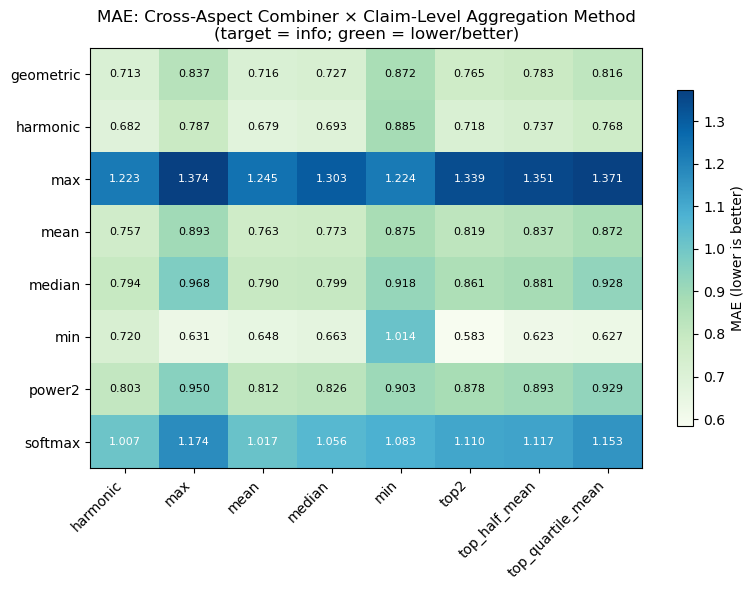

In [367]:
# This cell builds a heatmap of MAE for predicting utterance-level "info"
# using cross-aspect combiners (over novo/relv/imsc) × claim-level aggregation methods.
#
# It expects a DataFrame named `cl_soft` already in the environment with columns like:
# 'mean_info', 'max_info', ..., 'mean_novo', 'max_novo', ..., etc., and target 'info'.
#
# Outputs:
# - A DataFrame of MAE values (rows: cross-aspect combiners, cols: claim-level agg methods)
# - A matplotlib heatmap saved to /mnt/data/cross_aspect_agg_mae_heatmap.png
# - A CSV of the MAE grid saved to /mnt/data/cross_aspect_agg_mae_grid.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- sanity: check cl_soft exists ---
# try:
#     cl_soft
# except NameError as e:
#     raise SystemExit("`cl_soft` DataFrame not found in the environment. Please define it and rerun.")

# df = cl_soft.copy()

# Target
if "info" not in df.columns:
    raise SystemExit("The target column 'info' was not found in cl_soft.")

y = pd.to_numeric(df["info"], errors="coerce").values

# Per-aspect columns pattern mapping
claim_agg_map = {
    "mean": "mean_{a}",
    "max": "max_{a}",
    "min": "min_{a}",
    "median": "median_{a}",
    "harmonic": "harmonic_mean_{a}",
    "top2": "top2_{a}",
    # "top1": "top1_{a}",
    "top_quartile_mean": "top_quartile_mean_{a}",
    "top_half_mean": "top_half_mean_{a}",
}

# Limit to methods actually present for all three aspects
aspects = ["novo", "relv", "imsc"]

available_methods = []
missing_report = {}
for method, patt in claim_agg_map.items():
    needed = [patt.format(a=a) for a in aspects]
    missing = [c for c in needed if c not in df.columns]
    if not missing:
        available_methods.append(method)
    else:
        missing_report[method] = missing

# If nothing available, stop
if not available_methods:
    raise SystemExit(f"No complete method had all required columns. Missing: {missing_report}")

# helper: numeric matrix for a given method with shape (N, 3) for (novo, relv, imsc)
def get_matrix_for_method(method: str) -> np.ndarray:
    cols = [claim_agg_map[method].format(a=a) for a in aspects]
    M = df[cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)
    return M

# cross-aspect combiners (operate row-wise across the 3 aspect columns)
def comb_min(M):
    return np.nanmin(M, axis=1)

def comb_max(M):
    return np.nanmax(M, axis=1)

def comb_mean(M):
    return np.nanmean(M, axis=1)

def comb_median(M):
    return np.nanmedian(M, axis=1)

def comb_geometric(M):
    # geometric mean over positives; otherwise fall back to NaN for that row
    # (Scores are 1..4 typically, so positives; but we check anyway)
    Mp = np.where(M > 0, M, np.nan)
    with np.errstate(invalid="ignore"):
        return np.exp(np.nanmean(np.log(Mp), axis=1))

def comb_harmonic(M):
    # harmonic mean over positives; skip NaNs
    Mp = np.where(M > 0, M, np.nan)
    inv = 1.0 / Mp
    k = np.sum(np.isfinite(Mp), axis=1)
    s = np.nansum(inv, axis=1)
    out = np.full(M.shape[0], np.nan, dtype=float)
    mask = (k > 0) & np.isfinite(s) & (s > 0)
    out[mask] = k[mask] / s[mask]
    return out

def comb_power2(M):
    # Power mean with p=2
    return (np.nanmean(M**2, axis=1))**0.5

def comb_softmax(M):
    # Softmax-weighted average across aspects with fixed temperature
    # This keeps it unsupervised. tau=1.0
    tau = 1.0
    # handle NaNs: replace with very small to avoid dominating; then restore NaNs via mask
    R = M.copy()
    nanmask = ~np.isfinite(R)
    R[nanmask] = np.nanmin(R) if np.isfinite(np.nanmin(R)) else 0.0
    ex = np.exp((R - np.nanmax(R, axis=1, keepdims=True)) / tau)
    ex[nanmask] = 0.0
    w = ex / np.sum(ex, axis=1, keepdims=True)
    out = np.sum(w * R, axis=1)
    # rows that were all NaN remain NaN
    all_nan = np.all(~np.isfinite(M), axis=1)
    out[all_nan] = np.nan
    return out

comb_funcs = {
    "min": comb_min,
    "max": comb_max,
    "mean": comb_mean,
    "median": comb_median,
    "geometric": comb_geometric,
    "harmonic": comb_harmonic,
    "power2": comb_power2,
    "softmax": comb_softmax,
}

# Compute MAE grid
from sklearn.metrics import mean_absolute_error

mae_grid = pd.DataFrame(index=sorted(comb_funcs.keys()), columns=sorted(available_methods), dtype=float)

for method in sorted(available_methods):
    M = get_matrix_for_method(method)
    for comb_name, comb in comb_funcs.items():
        pred = comb(M)
        mask = np.isfinite(pred) & np.isfinite(y)
        if mask.sum() == 0:
            mae = np.nan
        else:
            mae = mean_absolute_error(y[mask], pred[mask])
        mae_grid.loc[comb_name, method] = mae

# Save grid
# os.makedirs("/mnt/data", exist_ok=True)
# csv_path = "/mnt/data/cross_aspect_agg_mae_grid.csv"
# mae_grid.to_csv(csv_path)

# Plot heatmap
plt.figure(figsize=(8, 6))

# Use a lighter diverging colormap where lower values are green (better)
cmap = plt.cm.GnBu   # green (low) → yellow → red (high)
vmin, vmax = np.nanmin(mae_grid.values), np.nanmax(mae_grid.values)

im = plt.imshow(mae_grid.values, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)

plt.xticks(ticks=np.arange(mae_grid.shape[1]), labels=mae_grid.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(mae_grid.shape[0]), labels=mae_grid.index)
plt.title("MAE: Cross-Aspect Combiner × Claim-Level Aggregation Method\n(target = info; green = lower/better)")

cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label("MAE (lower is better)")

# annotate values
mid = (vmin + vmax) / 2.0
for i in range(mae_grid.shape[0]):
    for j in range(mae_grid.shape[1]):
        val = mae_grid.values[i, j]
        if np.isfinite(val):
            # Use white text on darker (higher) regions, black on lighter (lower) ones
            txt_color = "white" if val > mid else "black"
            plt.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8, color=txt_color)

plt.tight_layout()
plt.show()

# csv_path, png_path


In [13]:
# Analysis against gpt-5_summary as ground truth
import copy

# Create a deep copy of runs to avoid modifying the original data
runs_for_analysis = copy.deepcopy(llm_runs)

# Use the first run gpt-5_summary as the ground truth
# Note: We assume gpt-5_summary is present in the runs
summary_gt_source = runs_for_analysis[0]["gpt-5_summary"]
ids = runs_for_analysis[0]["ids"]

# Construct new Ground Truth dictionary
summary_gt = {
    "ids": ids,
    "soft": summary_gt_source,
    "hard": summary_gt_source
}

# Remove gpt-5_summary from the runs to avoid comparing it to itself
for run in runs_for_analysis:
    if "gpt-5_summary" in run:
        del run["gpt-5_summary"]
    # Ensure hard/soft are removed if they exist
    if "hard" in run: del run["hard"]
    if "soft" in run: del run["soft"]

# Evaluate using the new ground truth
per_run_summary_vs_gpt5, agg_summary_vs_gpt5 = evaluate_llm_runs(runs_for_analysis, summary_gt)

print("Evaluation against gpt-5_summary (Run 0) as Ground Truth")
# Display only requested metrics
display(agg_summary_vs_gpt5[["method", "aspect", "mae_soft_mean", "pearson_soft_mean"]])

NameError: name 'llm_runs' is not defined